<a href="https://colab.research.google.com/github/loriboi/DT_suggerimento_contenuti/blob/main/DT_suggerimentocontenuti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Import librerie e cartella del progetto

Montaggio su drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import librerie, in main_folder indicare la cartella del progetto contenente i csv, nella stessa cartella verranno salvati i modelli

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score
import json
import joblib
main_folder = '/content/drive/MyDrive/ACCENTUREDT/'

##### Funzioni per il train

Salva le mappe

In [ ]:
def save_map(map,path):
  with open(path, "w") as file:
    json.dump(map, file)

Mappa gli attributi testuali del dataset

In [ ]:
def map_dataset(df,folder):
  categorie_uniche = pd.concat([df["categoria_preferita1"], df["categoria_preferita2"], df["categoria_preferita3"]]).unique()
  categorie_numeri = {categoria: indice for indice, categoria in enumerate(categorie_uniche)}
  nazionalita_uniche = df["nazionalita_utente"].unique()
  nazionalita_numeri = {nazionalita: indice for indice, nazionalita in enumerate(nazionalita_uniche)}
  occupazione_uniche = df["occupazione_utente"].unique()
  occupazione_numeri = {occupazione: indice for indice, occupazione in enumerate(occupazione_uniche)}
  contenuto_uniche = df["contenuto_preferito"].unique()
  contenuto_numeri = {contenuto: indice for indice, contenuto in enumerate(contenuto_uniche)}
  attore_uniche = df["attore_preferito"].unique()
  attore_numeri = {attore: indice for indice, attore in enumerate(attore_uniche)}
  regista_uniche = df["regista_preferito"].unique()
  regista_numeri = {regista: indice for indice, regista in enumerate(regista_uniche)}
  df["categoria_preferita1"] = df["categoria_preferita1"].map(categorie_numeri)
  df["categoria_preferita2"] = df["categoria_preferita2"].map(categorie_numeri)
  df["categoria_preferita3"] = df["categoria_preferita3"].map(categorie_numeri)
  df["nazionalita_utente"] = df["nazionalita_utente"].map(nazionalita_numeri)
  df["occupazione_utente"] = df["occupazione_utente"].map(occupazione_numeri)
  df["contenuto_preferito"] = df["contenuto_preferito"].map(contenuto_numeri)
  df["attore_preferito"] = df["attore_preferito"].map(attore_numeri)
  df["regista_preferito"] = df["regista_preferito"].map(regista_numeri)
  save_map(categorie_numeri,folder+"map_cat.json")
  save_map(nazionalita_numeri,folder+"map_naz.json")
  save_map(occupazione_numeri,folder+"map_occ.json")
  save_map(contenuto_numeri,folder+"map_cont.json")
  save_map(attore_numeri,folder+"map_act.json")
  save_map(regista_numeri,folder+"map_reg.json")
  maps = ["map_cat.json","map_naz.json","map_occ.json","map_cont.json","map_act.json","map_reg.json"]
  return (maps,df)


Train del primo modello

In [ ]:
def train_1(df,folder):
  X1 = df[['eta_utente', 'nazionalita_utente', 'occupazione_utente','categoria_preferita1','categoria_preferita2','categoria_preferita3']]
  scaler1 = StandardScaler()
  X1_scaled = scaler1.fit_transform(X1)
  kmeans1 = KMeans(n_clusters=5, random_state=42, n_init = 10)
  kmeans1.fit(X1_scaled)
  inertia1 = kmeans1.inertia_
  print(inertia1)
  df['Cluster'] = kmeans1.labels_
  namemodel1 = 'kmeans_model1.pkl'
  namedf1 = 'clustering_1df.csv'
  df.to_csv(folder+'clustering_1df.csv')
  joblib.dump(kmeans1, folder+'kmeans_model1.pkl')
  return (namemodel1,kmeans1,namedf1,df)

Train del secondo modello

In [ ]:
def train_2(df,folder):
  X2 = df[['eta_utente', 'nazionalita_utente', 'occupazione_utente','categoria_preferita1','categoria_preferita2','categoria_preferita3','durata_media_sessioni','durata_contenuto_preferito']]
  scaler2 = StandardScaler()
  X2_scaled = scaler2.fit_transform(X2)
  kmeans2 = KMeans(n_clusters=5, random_state=42, n_init = 10)
  kmeans2.fit(X2_scaled)
  inertia2 = kmeans2.inertia_
  print(inertia2)
  print(kmeans2.n_features_in_)
  df['Cluster'] = kmeans2.labels_
  namemodel2 = 'kmeans_model2.pkl'
  namedf2 = 'clustering_2df.csv'
  df.to_csv(folder+'clustering_2df.csv')
  joblib.dump(kmeans2, folder+'kmeans_model2.pkl')
  return (namemodel2,kmeans2,namedf2,df)

Plot in base a 3 assi

In [ ]:
def plot_3d(model,df,num_clusters):
  labels = model.labels_

  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(111, projection='3d')
  x = df['eta_utente']
  y = df['nazionalita_utente']
  z = df['occupazione_utente']

  for label in range(num_clusters):
      ax.scatter(x[labels == label], y[labels == label], z[labels == label], label=label)

  ax.set_xlabel('Età Utente')
  ax.set_ylabel('Nazionalità Utente')
  ax.set_zlabel('Occupazione Utente')
  ax.set_box_aspect([1,1,1])
  ax.margins(x=0.1, y=1, z=0.5)
  plt.legend()
  plt.show()

##### Funzioni per la classificazione

map_record1 e map_record2 servono a mappare gli attributi del nuovo record, sono diverse perchè nel tempo potrebbero crearsi nuove features testuali per uno dei due casi

In [ ]:
def map_record1(df,categorie_numeri,nazionalita_numeri,occupazione_numeri):
  df["categoria_preferita1"] = df["categoria_preferita1"].map(categorie_numeri)
  df["categoria_preferita2"] = df["categoria_preferita2"].map(categorie_numeri)
  df["categoria_preferita3"] = df["categoria_preferita3"].map(categorie_numeri)
  df["nazionalita_utente"] = df["nazionalita_utente"].map(nazionalita_numeri)
  df["occupazione_utente"] = df["occupazione_utente"].map(occupazione_numeri)
  return df

In [ ]:
def map_record2(df,categorie_numeri,nazionalita_numeri,occupazione_numeri,contenuto_numeri,attore_numeri,regista_numeri):
  df["categoria_preferita1"] = df["categoria_preferita1"].map(categorie_numeri)
  df["categoria_preferita2"] = df["categoria_preferita2"].map(categorie_numeri)
  df["categoria_preferita3"] = df["categoria_preferita3"].map(categorie_numeri)
  df["nazionalita_utente"] = df["nazionalita_utente"].map(nazionalita_numeri)
  df["occupazione_utente"] = df["occupazione_utente"].map(occupazione_numeri)
  return df

serve a verificare quale dei due modelli effettuerà la predizione

In [ ]:
def verifica_utente(dictionary_user):
    attributi_json1 = {'eta_utente', 'nazionalita_utente', 'occupazione_utente', 'categoria_preferita1', 'categoria_preferita2', 'categoria_preferita3'}
    attributi_json2 = {'eta_utente', 'nazionalita_utente', 'occupazione_utente', 'categoria_preferita1', 'categoria_preferita2', 'categoria_preferita3', 'durata_media_sessioni', 'durata_contenuto_preferito'}
    if all(attributo in dictionary_user for attributo in attributi_json2):
        return 2
    elif all(attributo in dictionary_user for attributo in attributi_json1):
        return 1
    else:
        return -1

assegna un utente a un cluster

In [ ]:
def classify_utente(dictionary_user,kmeans1,kmeans2,map_cat,map_naz,map_occ,map_cont,map_act,map_reg):
  type_user = verifica_utente(dictionary_user)
  if type_user == 1:
      new_record1 = pd.DataFrame(dictionary_user)
      new_record1 = map_record1(new_record1,map_cat,map_naz,map_occ)
      new_record1 = new_record1.values
      new_group1 = kmeans1.predict(new_record1)
      return (new_group1[0],type_user)
  elif type_user == 2:
      new_record2 = pd.DataFrame(dictionary_user)
      new_record2 = map_record2(new_record2,map_cat,map_naz,map_occ,map_cont,map_act,map_reg)
      new_record2 = new_record2.values
      new_group2 = kmeans2.predict(new_record2)
      return (new_group2[0],type_user)
  elif verifica_utente(dictionary_user) == -1:
      return (-1,-1)

##### Funzioni estrazione informazioni dal cluster

contenuti preferiti di un cluster

In [ ]:
def favourite_contents(model,df,cluster,mappa):
  df = df[df['Cluster'] == cluster]
  preferred_contents = df.groupby('Cluster')['contenuto_preferito'].apply(lambda x: x.value_counts().nlargest(2).index.tolist())
  mappa_invertita = {numero: nome for nome, numero in mappa.items()}
  preferred_names = preferred_contents.apply(lambda x: [mappa_invertita[numero] for numero in x])
  return preferred_names

attori preferiti di un cluster

In [ ]:
def favourite_actors(model,df,cluster,mappa):
  df = df[df['Cluster'] == cluster]
  preferred_actors = df.groupby('Cluster')['attore_preferito'].apply(lambda x: x.value_counts().nlargest(1).index.tolist())
  mappa_invertita = {numero: nome for nome, numero in mappa.items()}
  preferred_actors = preferred_actors.apply(lambda x: [mappa_invertita[numero] for numero in x])
  return preferred_actors

fornisce i contenuti da suggerire a un utente

In [ ]:
def get_suggestions(model1,model2,typeofuser,cluster,df1,df2,mappa):
  if typeofuser == 1:
    suggestions1 = favourite_contents(kmeans1,df1,cluster,mappa)
    return suggestions1
  elif typeofuser == 2:
    suggestions2 = favourite_contents(kmeans2,df2,cluster,mappa)
    return suggestions2


##### Train

caricamento del dataset e mappatura in valori interi

In [ ]:
path_train = main_folder + 'utenti_accenture_DT.csv'
df = pd.read_csv(path_train)
(maps,df_mapped) = map_dataset(df,main_folder)
df_mapped.to_csv(main_folder+"mapped_data.csv")
df_model1 = df_mapped.copy()
df_model2 = df_mapped.copy()

['map_cat.json', 'map_naz.json', 'map_occ.json', 'map_cont.json', 'map_act.json', 'map_reg.json']


addestramento primo modello

In [ ]:
(name_model1,kmeans1,name_df_cluster1,df_cluster1) = train_1(df_model1,main_folder)

501.03212249776726


addestramento secondo modello

In [ ]:
(name_model2,kmeans2,name_df_cluster2,df_cluster2) = train_2(df_model2,main_folder)

687.9964749072428
8


plot dei modelli 1 e 2

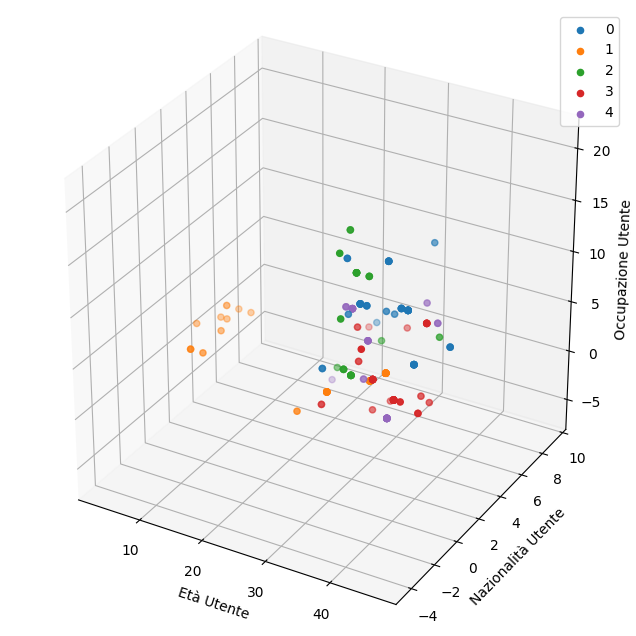

In [ ]:
plot_3d(kmeans1,df_cluster1,5)

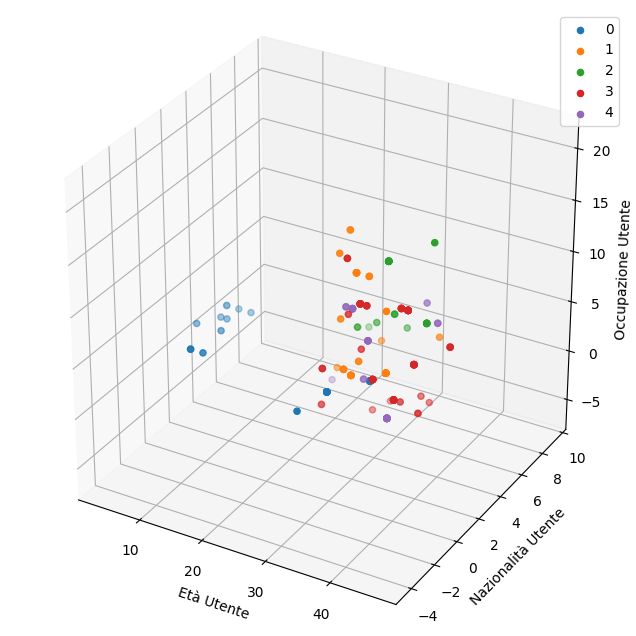

In [ ]:
plot_3d(kmeans2,df_cluster2,5)

##### Previsioni

###### Caricamento modelli e mappe

In [ ]:
kmeans_1 = joblib.load(main_folder+'kmeans_model1.pkl')
kmeans_2 = joblib.load(main_folder+'kmeans_model2.pkl')
df1 = pd.read_csv(main_folder+'clustering_1df.csv')
df2 = pd.read_csv(main_folder+'clustering_2df.csv')

with open(main_folder+'map_cont.json', 'r') as file:
    map_cont = json.load(file)

with open(main_folder+'map_cat.json', 'r') as file:
    map_cat = json.load(file)

with open(main_folder+'map_act.json', 'r') as file:
    map_act = json.load(file)

with open(main_folder+'map_naz.json', 'r') as file:
    map_naz = json.load(file)

with open(main_folder+'map_occ.json', 'r') as file:
    map_occ = json.load(file)

with open(main_folder+'map_reg.json', 'r') as file:
    map_reg = json.load(file)


###### Classificazione utente

In [ ]:
json1 = {
    'eta_utente':[30],
    'nazionalita_utente':['Italiana'],
    'occupazione_utente':['Studente'],
    'categoria_preferita1':['Horror'],
    'categoria_preferita2':['Commedia'],
    'categoria_preferita3':['Fantasy']
}

In [ ]:
(new_group1,typeofuser1) = classify_utente(json1,kmeans1, kmeans2, map_cat, map_naz, map_occ, map_cont, map_act, map_reg)

###### Suggerimenti dei film (in questo caso i film preferiti del suo cluster)

In [ ]:
suggerimenti_utente1 = get_suggestions(kmeans1,kmeans2,typeofuser1,new_group1,df1,df2,map_cont)

In [ ]:
print(suggerimenti_utente1)

Cluster
4    [Our Planet, Bohemian Rhapsody]
Name: contenuto_preferito, dtype: object


###### Attori preferiti per ogni cluster

In [ ]:
for i in range(0,5):
  print(favourite_actors(kmeans1,df1,i,map_act))

Cluster
0    [Matthew McConaughey]
Name: attore_preferito, dtype: object
Cluster
1    [Wagner Moura]
Name: attore_preferito, dtype: object
Cluster
2    [Evan Peters]
Name: attore_preferito, dtype: object
Cluster
3    [Ryan Gosling]
Name: attore_preferito, dtype: object
Cluster
4    [David Attenborough]
Name: attore_preferito, dtype: object
